# <p style="text-align: center;">Convolutional Neural Network (CNN) example in Keras <br>for classifying images
</p>

<p style="text-align: center;">
 by Prof. Dr.-Ing. Jürgen Brauer, http://www.juergenbrauer.org
</p>

## Table of Contents

1. Download some images
2. Check whether OpenCV is installed
3. Load one of the images and display it
4. Loading a batch of images
5. Prepare training and test data
6. Defining a CNN and training in Keras
7. Saving weights and model configuration
8. Plotting loss and accuracy curves
9. Restoring a previously saved model
10. Testing the trained model on new images

## 1. Download some images

We need training and test images. So let's download some!

Go to http://www.image-net.org/ and download test images for the following classes:
- birds (2126)
- mice (956)
- cats (1831)
- dogs (1603)
- horses (1402)

The number in the brackets specifies how much images I got from ImageNet for the corresponding class.

## 2. Check whether OpenCV is installed

In [1]:
import cv2
print("Your OpenCV version is: "+ cv2.__version__)

Your OpenCV version is: 3.4.0


## 3. Load one of the images and display it

In [2]:
import matplotlib.pyplot as plt

# 1.
# Load image and display information about it
#filename = "V:\\01_job\\12_datasets\\01_imagenet_birds\\n01503061_3.JPEG"
filename = "/home/paperspace/jb_datasets/01_imagenet_birds/n01503061_3.JPEG"
image = cv2.imread(filename)
print("Type of image is", type(image))
print("Image has dimensions :", image.shape)

# 2.
# OpenCV stores images in BGR color order,
# but MatplotLib expects RGB color order
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 3.
# Resize image to desired size
IMG_SIZE = (100,100)
image = cv2.resize(image, IMG_SIZE) 

# 4.
# Show image
plt.imshow(image)
plt.title("A bird")
plt.show()

Type of image is <class 'numpy.ndarray'>
Image has dimensions : (233, 350, 3)


<Figure size 640x480 with 1 Axes>

## 4. Loading a batch of images

Great! Now, that we have seen how to load images, we would like to load all bird images by some helper function and get all these images as a list:

In [3]:
from os import listdir
from os.path import isfile, join
import numpy as np

IMG_SIZE = (100,100)

def load_images(foldername):
    
    filenames = [f for f in listdir(foldername) if isfile(join(foldername, f))]
    nr_images = len(filenames)
    
    images = np.zeros((nr_images, IMG_SIZE[0], IMG_SIZE[1], 3))
        
    for img_nr,filename in enumerate(filenames):
        absolute_filename = foldername + "/" + filename
        image = cv2.imread(absolute_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMG_SIZE ) 
        image = image * (1.0/255.0)
        
        # set image in 4D array
        images[img_nr] = image
        
    print("I have read", len(filenames),
          "images from folder", foldername)
    return images
    
        
        
categories = ["birds", "mice", "cats", "dogs", "horses"]
#root_dir = "V:\\01_job\\12_datasets\\"
root_dir = "/home/paperspace/jb_datasets/"
folder_per_cat = {"birds"  : root_dir+"01_imagenet_birds",
                  "mice"   : root_dir+"02_imagenet_mice",
                  "cats"   : root_dir+"03_imagenet_cats",
                  "dogs"   : root_dir+"04_imagenet_dogs",
                  "horses" : root_dir+"05_imagenet_horses"}

bird_images   = load_images(folder_per_cat["birds"])
mice_images   = load_images(folder_per_cat["mice"])
cats_images   = load_images(folder_per_cat["cats"])
dogs_images   = load_images(folder_per_cat["dogs"])
horses_images = load_images(folder_per_cat["horses"])

I have read 2126 images from folder /home/paperspace/jb_datasets/01_imagenet_birds
I have read 956 images from folder /home/paperspace/jb_datasets/02_imagenet_mice
I have read 1831 images from folder /home/paperspace/jb_datasets/03_imagenet_cats
I have read 1603 images from folder /home/paperspace/jb_datasets/04_imagenet_dogs
I have read 1402 images from folder /home/paperspace/jb_datasets/05_imagenet_horses


## 5. Prepare training and test data

Image training data for a CNN in Keras is expected to be a 4D NumPy array of shape:

    nr_images x img_height x img_width x nr_channels
    
For shuffling the training images, we use the permutation class of NumPy:

In [4]:
test_array = np.arange(10).reshape((5, 2))
permut = np.random.permutation(test_array.shape[0])
print("permut=",permut)
print("test_array before:", test_array)
test_array = np.take(test_array, permut, axis=0)
print("test_array after:", test_array)


permut= [3 2 1 4 0]
test_array before: [[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
test_array after: [[6 7]
 [4 5]
 [2 3]
 [8 9]
 [0 1]]


In [5]:
print("bird_images has shape",bird_images.shape)
print("mice_images has shape",mice_images.shape)

labels_bird_images = np.zeros( (bird_images.shape[0],1) )
labels_bird_images[:,0] = 0

labels_mice_images = np.zeros( (mice_images.shape[0],1) )
labels_mice_images[:,0] = 1

labels_cats_images = np.zeros( (cats_images.shape[0],1) )
labels_cats_images[:,0] = 2

labels_dogs_images = np.zeros( (dogs_images.shape[0],1) )
labels_dogs_images[:,0] = 3

labels_horses_images = np.zeros( (horses_images.shape[0],1) )
labels_horses_images[:,0] = 4

X = np.vstack((bird_images,
               mice_images,
               cats_images,
               dogs_images,
               horses_images))
print("X has shape", X.shape)

Y = np.vstack( (labels_bird_images,
                labels_mice_images,
                labels_cats_images,
                labels_dogs_images,
                labels_horses_images))
print("Y has shape", Y.shape)

# Shuffle data
some_permutation = np.random.permutation(X.shape[0])
X = np.take(X,some_permutation,axis=0)
Y = np.take(Y,some_permutation,axis=0)

# Split data into training and testing data
TEST_DATA_RATIO = 0.1
nr_train_images = int((1-TEST_DATA_RATIO)*X.shape[0])
print("The", X.shape[0], "many images will be split "
      "into train and test images.")
X_train = X[0:nr_train_images]
Y_train = Y[0:nr_train_images]
X_test  = X[nr_train_images:]
Y_test  = Y[nr_train_images:]
print("Shape of X_train is", X_train.shape)
print("Shape of X_test is", X_test.shape)


bird_images has shape (2126, 100, 100, 3)
mice_images has shape (956, 100, 100, 3)
X has shape (7918, 100, 100, 3)
Y has shape (7918, 1)
The 7918 many images will be split into train and test images.
Shape of X_train is (7126, 100, 100, 3)
Shape of X_test is (792, 100, 100, 3)


Now we will prepare a one-hot encoding for the training data labels, which are between 0 and 4.

In [6]:
from keras.utils import to_categorical

print(Y_train)
Y_train_one_hot_encoded = to_categorical(Y_train)
print(Y_train_one_hot_encoded)
Y_test_one_hot_encoded = to_categorical(Y_test)

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[[0.]
 [4.]
 [3.]
 ...
 [2.]
 [1.]
 [2.]]
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


## 6. Defining a CNN and training in Keras

Now let's define a CNN model and feed it with the training images.



In [9]:
import keras
from keras import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization

NUM_CLASSES = 5
NR_EPOCHS_TO_TRAIN = 2500

# 1.
# Define the input shape of the CNN:
# img_height x img_width x nr_channels
the_input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)


# 2.
# Define the CNN model
# See https://github.com/eweill/keras-deepcv/blob/master/models/classification/alexnet.py
def a_simple_cnn():

    # Initialize model
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape=the_input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.33))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model
    
model = a_simple_cnn()


# 3.
# Compile model and show model summary


model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


# 4.
# Train model
print("Training input data has shape", X_train.shape)
print("Training output data has shape", Y_train_one_hot_encoded.shape)
        
history = model.fit(X_train, Y_train_one_hot_encoded,
                    validation_split=0.25, batch_size=64, epochs=NR_EPOCHS_TO_TRAIN)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 96, 96, 32)        2432      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 47, 47, 64)        8256      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 22, 22, 64)        16448     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 10, 10, 64)        16448     
__________

5344/5344 [==============================] - 3s 570us/step - loss: 1.2335 - acc: 0.5022 - val_loss: 1.2903 - val_acc: 0.4697
Epoch 103/2500
5344/5344 [==============================] - 3s 567us/step - loss: 1.2307 - acc: 0.4968 - val_loss: 1.2993 - val_acc: 0.4675
Epoch 104/2500
5344/5344 [==============================] - 3s 563us/step - loss: 1.2253 - acc: 0.4998 - val_loss: 1.3116 - val_acc: 0.4416
Epoch 105/2500
5344/5344 [==============================] - 3s 567us/step - loss: 1.2280 - acc: 0.4996 - val_loss: 1.2960 - val_acc: 0.4691
Epoch 106/2500
5344/5344 [==============================] - 3s 570us/step - loss: 1.2101 - acc: 0.5105 - val_loss: 1.2952 - val_acc: 0.4646
Epoch 107/2500
5344/5344 [==============================] - 3s 565us/step - loss: 1.2122 - acc: 0.5075 - val_loss: 1.2884 - val_acc: 0.4680
Epoch 108/2500
5344/5344 [==============================] - 3s 566us/step - loss: 1.2097 - acc: 0.5086 - val_loss: 1.3164 - val_acc: 0.4534
Epoch 109/2500
5344/5344 [=========

5344/5344 [==============================] - 3s 570us/step - loss: 0.6258 - acc: 0.7487 - val_loss: 1.7606 - val_acc: 0.4731
Epoch 219/2500
5344/5344 [==============================] - 3s 568us/step - loss: 0.6525 - acc: 0.7354 - val_loss: 1.6825 - val_acc: 0.4719
Epoch 220/2500
5344/5344 [==============================] - 3s 567us/step - loss: 0.6201 - acc: 0.7481 - val_loss: 1.7446 - val_acc: 0.4747
Epoch 221/2500
5344/5344 [==============================] - 3s 566us/step - loss: 0.6090 - acc: 0.7517 - val_loss: 1.7350 - val_acc: 0.4646
Epoch 222/2500
5344/5344 [==============================] - 3s 569us/step - loss: 0.6144 - acc: 0.7521 - val_loss: 1.7600 - val_acc: 0.4832
Epoch 223/2500
5344/5344 [==============================] - 3s 567us/step - loss: 0.6210 - acc: 0.7479 - val_loss: 1.9187 - val_acc: 0.4736
Epoch 224/2500
5344/5344 [==============================] - 3s 569us/step - loss: 0.6053 - acc: 0.7504 - val_loss: 1.7645 - val_acc: 0.4764
Epoch 225/2500
5344/5344 [=========

5344/5344 [==============================] - 3s 571us/step - loss: 0.2045 - acc: 0.9238 - val_loss: 3.9115 - val_acc: 0.4557
Epoch 335/2500
5344/5344 [==============================] - 3s 573us/step - loss: 0.1622 - acc: 0.9375 - val_loss: 3.9618 - val_acc: 0.4602
Epoch 336/2500
5344/5344 [==============================] - 3s 575us/step - loss: 0.1741 - acc: 0.9311 - val_loss: 3.7787 - val_acc: 0.4478
Epoch 337/2500
5344/5344 [==============================] - 3s 571us/step - loss: 0.1788 - acc: 0.9281 - val_loss: 4.0116 - val_acc: 0.4405
Epoch 338/2500
5344/5344 [==============================] - 3s 573us/step - loss: 0.1855 - acc: 0.9308 - val_loss: 3.8535 - val_acc: 0.4579
Epoch 339/2500
5344/5344 [==============================] - 3s 570us/step - loss: 0.1931 - acc: 0.9280 - val_loss: 3.9855 - val_acc: 0.4590
Epoch 340/2500
5344/5344 [==============================] - 3s 568us/step - loss: 0.1703 - acc: 0.9328 - val_loss: 4.2409 - val_acc: 0.4551
Epoch 341/2500
5344/5344 [=========

5344/5344 [==============================] - 3s 554us/step - loss: 0.0839 - acc: 0.9702 - val_loss: 5.0079 - val_acc: 0.4585
Epoch 451/2500
5344/5344 [==============================] - 3s 554us/step - loss: 0.0833 - acc: 0.9673 - val_loss: 4.9955 - val_acc: 0.4568
Epoch 452/2500
5344/5344 [==============================] - 3s 551us/step - loss: 0.2438 - acc: 0.9311 - val_loss: 4.6085 - val_acc: 0.4400
Epoch 453/2500
5344/5344 [==============================] - 3s 549us/step - loss: 0.0975 - acc: 0.9620 - val_loss: 4.8412 - val_acc: 0.4512
Epoch 454/2500
5344/5344 [==============================] - 3s 547us/step - loss: 0.0742 - acc: 0.9729 - val_loss: 5.0434 - val_acc: 0.4562
Epoch 455/2500
5344/5344 [==============================] - 3s 550us/step - loss: 0.0861 - acc: 0.9686 - val_loss: 5.0104 - val_acc: 0.4579
Epoch 456/2500
5344/5344 [==============================] - 3s 549us/step - loss: 0.0851 - acc: 0.9684 - val_loss: 5.0329 - val_acc: 0.4624
Epoch 457/2500
5344/5344 [=========

5344/5344 [==============================] - 3s 540us/step - loss: 0.0543 - acc: 0.9802 - val_loss: 5.7154 - val_acc: 0.4422
Epoch 567/2500
5344/5344 [==============================] - 3s 544us/step - loss: 0.0528 - acc: 0.9787 - val_loss: 5.7965 - val_acc: 0.4360
Epoch 568/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.0452 - acc: 0.9839 - val_loss: 5.7196 - val_acc: 0.4495
Epoch 569/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.0486 - acc: 0.9822 - val_loss: 5.7828 - val_acc: 0.4501
Epoch 570/2500
5344/5344 [==============================] - 3s 533us/step - loss: 0.0531 - acc: 0.9830 - val_loss: 6.1192 - val_acc: 0.4394
Epoch 571/2500
5344/5344 [==============================] - 3s 542us/step - loss: 0.0548 - acc: 0.9804 - val_loss: 5.5714 - val_acc: 0.4467
Epoch 572/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.0708 - acc: 0.9768 - val_loss: 5.6159 - val_acc: 0.4562
Epoch 573/2500
5344/5344 [=========

5344/5344 [==============================] - 3s 540us/step - loss: 0.2162 - acc: 0.9424 - val_loss: 5.5700 - val_acc: 0.4557
Epoch 683/2500
5344/5344 [==============================] - 3s 543us/step - loss: 0.0444 - acc: 0.9843 - val_loss: 5.9816 - val_acc: 0.4416
Epoch 684/2500
5344/5344 [==============================] - 3s 537us/step - loss: 0.0837 - acc: 0.9732 - val_loss: 5.6820 - val_acc: 0.4484
Epoch 685/2500
5344/5344 [==============================] - 3s 540us/step - loss: 0.0737 - acc: 0.9753 - val_loss: 5.1258 - val_acc: 0.4315
Epoch 686/2500
5344/5344 [==============================] - 3s 537us/step - loss: 0.2783 - acc: 0.9296 - val_loss: 4.5098 - val_acc: 0.4299
Epoch 687/2500
5344/5344 [==============================] - 3s 539us/step - loss: 0.1026 - acc: 0.9658 - val_loss: 5.5556 - val_acc: 0.4388
Epoch 688/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.0522 - acc: 0.9822 - val_loss: 5.7871 - val_acc: 0.4332
Epoch 689/2500
5344/5344 [=========

5344/5344 [==============================] - 3s 540us/step - loss: 0.0287 - acc: 0.9897 - val_loss: 6.3668 - val_acc: 0.4338
Epoch 799/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.0237 - acc: 0.9910 - val_loss: 6.4669 - val_acc: 0.4450
Epoch 800/2500
5344/5344 [==============================] - 3s 536us/step - loss: 0.0333 - acc: 0.9873 - val_loss: 6.2650 - val_acc: 0.4439
Epoch 801/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.0258 - acc: 0.9895 - val_loss: 6.3885 - val_acc: 0.4574
Epoch 802/2500
5344/5344 [==============================] - 3s 546us/step - loss: 0.0265 - acc: 0.9905 - val_loss: 6.3574 - val_acc: 0.4411
Epoch 803/2500
5344/5344 [==============================] - 3s 543us/step - loss: 0.0257 - acc: 0.9901 - val_loss: 6.5066 - val_acc: 0.4422
Epoch 804/2500
5344/5344 [==============================] - 3s 544us/step - loss: 0.0218 - acc: 0.9920 - val_loss: 6.4889 - val_acc: 0.4484
Epoch 805/2500
5344/5344 [=========

5344/5344 [==============================] - 3s 535us/step - loss: 0.0365 - acc: 0.9878 - val_loss: 6.1276 - val_acc: 0.4400
Epoch 915/2500
5344/5344 [==============================] - 3s 533us/step - loss: 0.0316 - acc: 0.9878 - val_loss: 6.2051 - val_acc: 0.4501
Epoch 916/2500
5344/5344 [==============================] - 3s 536us/step - loss: 0.0225 - acc: 0.9933 - val_loss: 6.3734 - val_acc: 0.4416
Epoch 917/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.1202 - acc: 0.9635 - val_loss: 5.4442 - val_acc: 0.4231
Epoch 918/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.0454 - acc: 0.9828 - val_loss: 5.8362 - val_acc: 0.4456
Epoch 919/2500
5344/5344 [==============================] - 3s 536us/step - loss: 0.0268 - acc: 0.9908 - val_loss: 6.2116 - val_acc: 0.4489
Epoch 920/2500
5344/5344 [==============================] - 3s 539us/step - loss: 0.0321 - acc: 0.9895 - val_loss: 6.4765 - val_acc: 0.4501
Epoch 921/2500
5344/5344 [=========

5344/5344 [==============================] - 3s 536us/step - loss: 0.0271 - acc: 0.9906 - val_loss: 6.5457 - val_acc: 0.4237
Epoch 1031/2500
5344/5344 [==============================] - 3s 541us/step - loss: 0.0274 - acc: 0.9905 - val_loss: 6.2922 - val_acc: 0.4473
Epoch 1032/2500
5344/5344 [==============================] - 3s 544us/step - loss: 0.0231 - acc: 0.9916 - val_loss: 6.5776 - val_acc: 0.4461
Epoch 1033/2500
5344/5344 [==============================] - 3s 540us/step - loss: 0.0205 - acc: 0.9914 - val_loss: 6.7722 - val_acc: 0.4377
Epoch 1034/2500
5344/5344 [==============================] - 3s 537us/step - loss: 0.0544 - acc: 0.9839 - val_loss: 5.9885 - val_acc: 0.4321
Epoch 1035/2500
5344/5344 [==============================] - 3s 540us/step - loss: 0.0313 - acc: 0.9884 - val_loss: 6.3166 - val_acc: 0.4506
Epoch 1036/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.0280 - acc: 0.9903 - val_loss: 6.4384 - val_acc: 0.4478
Epoch 1037/2500
5344/5344 [==

5344/5344 [==============================] - 3s 570us/step - loss: 0.0160 - acc: 0.9938 - val_loss: 6.6613 - val_acc: 0.4540
Epoch 1147/2500
5344/5344 [==============================] - 3s 571us/step - loss: 0.0173 - acc: 0.9920 - val_loss: 6.8081 - val_acc: 0.4574
Epoch 1148/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.0161 - acc: 0.9940 - val_loss: 6.8487 - val_acc: 0.4411
Epoch 1149/2500
5344/5344 [==============================] - 3s 543us/step - loss: 0.0434 - acc: 0.9863 - val_loss: 6.7204 - val_acc: 0.4428
Epoch 1150/2500
5344/5344 [==============================] - 3s 537us/step - loss: 0.0333 - acc: 0.9882 - val_loss: 6.6328 - val_acc: 0.4456
Epoch 1151/2500
5344/5344 [==============================] - 3s 541us/step - loss: 0.0267 - acc: 0.9903 - val_loss: 6.4032 - val_acc: 0.4467
Epoch 1152/2500
5344/5344 [==============================] - 3s 546us/step - loss: 0.0217 - acc: 0.9920 - val_loss: 6.4739 - val_acc: 0.4501
Epoch 1153/2500
5344/5344 [==

5344/5344 [==============================] - 3s 543us/step - loss: 0.0172 - acc: 0.9931 - val_loss: 6.7995 - val_acc: 0.4512
Epoch 1263/2500
5344/5344 [==============================] - 3s 537us/step - loss: 0.0205 - acc: 0.9921 - val_loss: 6.5943 - val_acc: 0.4484
Epoch 1264/2500
5344/5344 [==============================] - 3s 540us/step - loss: 0.0145 - acc: 0.9942 - val_loss: 6.7420 - val_acc: 0.4529
Epoch 1265/2500
5344/5344 [==============================] - 3s 543us/step - loss: 0.0145 - acc: 0.9942 - val_loss: 6.7706 - val_acc: 0.4416
Epoch 1266/2500
5344/5344 [==============================] - 3s 541us/step - loss: 0.0168 - acc: 0.9936 - val_loss: 6.8514 - val_acc: 0.4433
Epoch 1267/2500
5344/5344 [==============================] - 3s 539us/step - loss: 0.0214 - acc: 0.9938 - val_loss: 6.6428 - val_acc: 0.4433
Epoch 1268/2500
5344/5344 [==============================] - 3s 537us/step - loss: 0.0152 - acc: 0.9944 - val_loss: 6.6909 - val_acc: 0.4428
Epoch 1269/2500
5344/5344 [==

5344/5344 [==============================] - 3s 539us/step - loss: 0.0131 - acc: 0.9951 - val_loss: 6.9351 - val_acc: 0.4439
Epoch 1379/2500
5344/5344 [==============================] - 3s 542us/step - loss: 0.0124 - acc: 0.9963 - val_loss: 6.9236 - val_acc: 0.4478
Epoch 1380/2500
5344/5344 [==============================] - 3s 536us/step - loss: 0.0103 - acc: 0.9968 - val_loss: 6.9017 - val_acc: 0.4433
Epoch 1381/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.0142 - acc: 0.9944 - val_loss: 6.8998 - val_acc: 0.4411
Epoch 1382/2500
5344/5344 [==============================] - 3s 541us/step - loss: 0.0107 - acc: 0.9959 - val_loss: 6.8583 - val_acc: 0.4517
Epoch 1383/2500
5344/5344 [==============================] - 3s 539us/step - loss: 0.0144 - acc: 0.9942 - val_loss: 6.8484 - val_acc: 0.4428
Epoch 1384/2500
5344/5344 [==============================] - 3s 536us/step - loss: 0.0152 - acc: 0.9946 - val_loss: 6.8305 - val_acc: 0.4439
Epoch 1385/2500
5344/5344 [==

5344/5344 [==============================] - 3s 536us/step - loss: 0.0202 - acc: 0.9935 - val_loss: 6.6734 - val_acc: 0.4568
Epoch 1495/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.0100 - acc: 0.9964 - val_loss: 6.7250 - val_acc: 0.4590
Epoch 1496/2500
5344/5344 [==============================] - 3s 533us/step - loss: 0.0181 - acc: 0.9925 - val_loss: 6.6825 - val_acc: 0.4574
Epoch 1497/2500
5344/5344 [==============================] - 3s 540us/step - loss: 0.0143 - acc: 0.9942 - val_loss: 6.7558 - val_acc: 0.4557
Epoch 1498/2500
5344/5344 [==============================] - 3s 534us/step - loss: 0.0110 - acc: 0.9959 - val_loss: 6.8099 - val_acc: 0.4562
Epoch 1499/2500
5344/5344 [==============================] - 3s 537us/step - loss: 0.0136 - acc: 0.9949 - val_loss: 6.7710 - val_acc: 0.4545
Epoch 1500/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.0187 - acc: 0.9933 - val_loss: 6.6305 - val_acc: 0.4473
Epoch 1501/2500
5344/5344 [==

5344/5344 [==============================] - 3s 535us/step - loss: 0.0114 - acc: 0.9955 - val_loss: 6.9351 - val_acc: 0.4422
Epoch 1611/2500
5344/5344 [==============================] - 3s 535us/step - loss: 0.0123 - acc: 0.9949 - val_loss: 6.9139 - val_acc: 0.4517
Epoch 1612/2500
5344/5344 [==============================] - 3s 537us/step - loss: 0.0163 - acc: 0.9936 - val_loss: 6.7584 - val_acc: 0.4473
Epoch 1613/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.0191 - acc: 0.9929 - val_loss: 6.7993 - val_acc: 0.4461
Epoch 1614/2500
5344/5344 [==============================] - 3s 540us/step - loss: 0.0142 - acc: 0.9938 - val_loss: 6.9051 - val_acc: 0.4501
Epoch 1615/2500
5344/5344 [==============================] - 3s 541us/step - loss: 0.0260 - acc: 0.9912 - val_loss: 6.9437 - val_acc: 0.4473
Epoch 1616/2500
5344/5344 [==============================] - 3s 540us/step - loss: 0.0180 - acc: 0.9953 - val_loss: 6.6221 - val_acc: 0.4411
Epoch 1617/2500
5344/5344 [==

5344/5344 [==============================] - 3s 539us/step - loss: 0.0127 - acc: 0.9955 - val_loss: 7.0923 - val_acc: 0.4484
Epoch 1727/2500
5344/5344 [==============================] - 3s 543us/step - loss: 0.0130 - acc: 0.9955 - val_loss: 6.9768 - val_acc: 0.4450
Epoch 1728/2500
5344/5344 [==============================] - 3s 537us/step - loss: 0.0163 - acc: 0.9949 - val_loss: 6.8317 - val_acc: 0.4422
Epoch 1729/2500
5344/5344 [==============================] - 3s 539us/step - loss: 0.0112 - acc: 0.9963 - val_loss: 6.8740 - val_acc: 0.4517
Epoch 1730/2500
5344/5344 [==============================] - 3s 539us/step - loss: 0.0125 - acc: 0.9955 - val_loss: 6.8421 - val_acc: 0.4512
Epoch 1731/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.0120 - acc: 0.9963 - val_loss: 6.9675 - val_acc: 0.4495
Epoch 1732/2500
5344/5344 [==============================] - 3s 540us/step - loss: 0.0115 - acc: 0.9963 - val_loss: 6.9134 - val_acc: 0.4450
Epoch 1733/2500
5344/5344 [==

5344/5344 [==============================] - 3s 538us/step - loss: 0.0080 - acc: 0.9966 - val_loss: 7.1205 - val_acc: 0.4355
Epoch 1843/2500
5344/5344 [==============================] - 3s 537us/step - loss: 0.0137 - acc: 0.9946 - val_loss: 7.0850 - val_acc: 0.4428
Epoch 1844/2500
5344/5344 [==============================] - 3s 536us/step - loss: 0.0126 - acc: 0.9951 - val_loss: 7.1804 - val_acc: 0.4428
Epoch 1845/2500
5344/5344 [==============================] - 3s 537us/step - loss: 0.0103 - acc: 0.9959 - val_loss: 7.0889 - val_acc: 0.4489
Epoch 1846/2500
5344/5344 [==============================] - 3s 545us/step - loss: 0.0107 - acc: 0.9957 - val_loss: 7.1083 - val_acc: 0.4366
Epoch 1847/2500
5344/5344 [==============================] - 3s 543us/step - loss: 0.0107 - acc: 0.9963 - val_loss: 7.0604 - val_acc: 0.4456
Epoch 1848/2500
5344/5344 [==============================] - 3s 541us/step - loss: 0.0098 - acc: 0.9959 - val_loss: 7.1220 - val_acc: 0.4422
Epoch 1849/2500
5344/5344 [==

5344/5344 [==============================] - 3s 541us/step - loss: 0.0254 - acc: 0.9908 - val_loss: 6.4855 - val_acc: 0.4428
Epoch 1959/2500
5344/5344 [==============================] - 3s 536us/step - loss: 0.0169 - acc: 0.9940 - val_loss: 6.7550 - val_acc: 0.4428
Epoch 1960/2500
5344/5344 [==============================] - 3s 539us/step - loss: 0.0164 - acc: 0.9944 - val_loss: 6.8032 - val_acc: 0.4523
Epoch 1961/2500
5344/5344 [==============================] - 3s 534us/step - loss: 0.0151 - acc: 0.9935 - val_loss: 6.8933 - val_acc: 0.4411
Epoch 1962/2500
5344/5344 [==============================] - 3s 533us/step - loss: 0.0144 - acc: 0.9955 - val_loss: 6.9890 - val_acc: 0.4416
Epoch 1963/2500
5344/5344 [==============================] - 3s 537us/step - loss: 0.0239 - acc: 0.9906 - val_loss: 7.1090 - val_acc: 0.4276
Epoch 1964/2500
5344/5344 [==============================] - 3s 539us/step - loss: 0.0174 - acc: 0.9933 - val_loss: 6.8552 - val_acc: 0.4338
Epoch 1965/2500
5344/5344 [==

5344/5344 [==============================] - 3s 538us/step - loss: 0.0152 - acc: 0.9944 - val_loss: 6.9184 - val_acc: 0.4574
Epoch 2075/2500
5344/5344 [==============================] - 3s 536us/step - loss: 0.0138 - acc: 0.9944 - val_loss: 6.8121 - val_acc: 0.4557
Epoch 2076/2500
5344/5344 [==============================] - 3s 541us/step - loss: 0.0241 - acc: 0.9927 - val_loss: 6.9285 - val_acc: 0.4478
Epoch 2077/2500
5344/5344 [==============================] - 3s 536us/step - loss: 0.0811 - acc: 0.9804 - val_loss: 6.4965 - val_acc: 0.4377
Epoch 2078/2500
5344/5344 [==============================] - 3s 538us/step - loss: 0.0340 - acc: 0.9890 - val_loss: 6.4991 - val_acc: 0.4327
Epoch 2079/2500
5344/5344 [==============================] - 3s 536us/step - loss: 0.0163 - acc: 0.9944 - val_loss: 6.8684 - val_acc: 0.4484
Epoch 2080/2500
5344/5344 [==============================] - 3s 539us/step - loss: 0.0154 - acc: 0.9946 - val_loss: 6.9105 - val_acc: 0.4343
Epoch 2081/2500
5344/5344 [==

5344/5344 [==============================] - 3s 540us/step - loss: 0.0096 - acc: 0.9966 - val_loss: 7.1176 - val_acc: 0.4444
Epoch 2191/2500
5344/5344 [==============================] - 3s 539us/step - loss: 0.0134 - acc: 0.9946 - val_loss: 6.9745 - val_acc: 0.4501
Epoch 2192/2500
5344/5344 [==============================] - 3s 539us/step - loss: 0.0099 - acc: 0.9961 - val_loss: 7.0746 - val_acc: 0.4439
Epoch 2193/2500
5344/5344 [==============================] - 3s 533us/step - loss: 0.0120 - acc: 0.9955 - val_loss: 7.0655 - val_acc: 0.4512
Epoch 2194/2500
5344/5344 [==============================] - 3s 541us/step - loss: 0.0120 - acc: 0.9949 - val_loss: 7.0893 - val_acc: 0.4495
Epoch 2195/2500
5344/5344 [==============================] - 3s 541us/step - loss: 0.0164 - acc: 0.9953 - val_loss: 7.0622 - val_acc: 0.4444
Epoch 2196/2500
5344/5344 [==============================] - 3s 542us/step - loss: 0.0174 - acc: 0.9929 - val_loss: 7.0412 - val_acc: 0.4484
Epoch 2197/2500
5344/5344 [==

5344/5344 [==============================] - 3s 536us/step - loss: 0.0153 - acc: 0.9942 - val_loss: 7.1503 - val_acc: 0.4411
Epoch 2307/2500
5344/5344 [==============================] - 3s 542us/step - loss: 0.0118 - acc: 0.9951 - val_loss: 7.0741 - val_acc: 0.4411
Epoch 2308/2500
5344/5344 [==============================] - 3s 536us/step - loss: 0.0104 - acc: 0.9951 - val_loss: 7.0494 - val_acc: 0.4416
Epoch 2309/2500
5344/5344 [==============================] - 3s 537us/step - loss: 0.0125 - acc: 0.9946 - val_loss: 7.1064 - val_acc: 0.4394
Epoch 2310/2500
5344/5344 [==============================] - 3s 537us/step - loss: 0.0131 - acc: 0.9953 - val_loss: 7.0545 - val_acc: 0.4467
Epoch 2311/2500
5344/5344 [==============================] - 3s 536us/step - loss: 0.0156 - acc: 0.9944 - val_loss: 7.1527 - val_acc: 0.4450
Epoch 2312/2500
5344/5344 [==============================] - 3s 543us/step - loss: 0.0178 - acc: 0.9933 - val_loss: 7.0508 - val_acc: 0.4343
Epoch 2313/2500
5344/5344 [==

5344/5344 [==============================] - 3s 536us/step - loss: 0.0114 - acc: 0.9963 - val_loss: 6.9897 - val_acc: 0.4456
Epoch 2423/2500
5344/5344 [==============================] - 3s 541us/step - loss: 0.0148 - acc: 0.9936 - val_loss: 7.1952 - val_acc: 0.4360
Epoch 2424/2500
5344/5344 [==============================] - 3s 539us/step - loss: 0.0091 - acc: 0.9964 - val_loss: 7.1426 - val_acc: 0.4405
Epoch 2425/2500
5344/5344 [==============================] - 3s 534us/step - loss: 0.0103 - acc: 0.9961 - val_loss: 7.1376 - val_acc: 0.4405
Epoch 2426/2500
5344/5344 [==============================] - 3s 536us/step - loss: 0.0094 - acc: 0.9964 - val_loss: 7.1842 - val_acc: 0.4478
Epoch 2427/2500
5344/5344 [==============================] - 3s 537us/step - loss: 0.0101 - acc: 0.9959 - val_loss: 7.2161 - val_acc: 0.4428
Epoch 2428/2500
5344/5344 [==============================] - 3s 536us/step - loss: 0.0117 - acc: 0.9959 - val_loss: 7.2165 - val_acc: 0.4484
Epoch 2429/2500
5344/5344 [==

Why are there 2432 parameters for the first CONV layer?
Each of the 32 filters gets inputs from 5x5x3 input values = 32*75 = 2400. And do not forget that each filter has a single bias value --> 2432 weights.

Why are there 51264 parameters for the second CONV layer?
Each of the 64 filters gets input from 5x5x32 input values = 64*5*5*32 = 51200. And do not forget that each filter has a single bias value --> 51264 weights.

Why are there 14.137.700 parameters in the first dense layer?
Each of the 100 neurons in this layers gets input from the flatten layer, which contains 47*47*64=141.376 values --> 141.376*100 = 14.137.600 weights. And do not forget that each neuron has a single bias value --> 14.137.700 weights!


## 7. Saving weights and model configuration

Training a CNN can take a long time! So it is a good idea to save the model and the weights and reload both if it is time for inference.

In [10]:
# Save the weights
model.save_weights('model_weights.h5')

# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

This will generate two files:

    - model_architecture.json (ca. 3 KB)
    - model_weights.h5 (ca. 55 MB!)


## 8. Plotting loss and accuracy curves

The following keys are stored in the training history:
 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
loss history has len 2500
[1.596446905307427, 1.5876611706739414, 1.5842713617279145, 1.5808261811376332, 1.5768952912199283, 1.5742356798606005, 1.5731471312974028, 1.5698022364142412, 1.567796617210982, 1.5643249243319393, 1.56124301870426, 1.5541975619550237, 1.5500204013493246, 1.5445513254154228, 1.5413926133138691, 1.535758648803848, 1.52323449585966, 1.5222763301369673, 1.5075806286520588, 1.5013627848939268, 1.504598177835613, 1.4923162802964627, 1.4954123097265553, 1.4842988887946762, 1.4861600484676705, 1.4829760325882964, 1.4766670729585751, 1.4774284748260134, 1.466608913358814, 1.4540427452075981, 1.4557343585762434, 1.4537127439133422, 1.4484956400123186, 1.4361436388449755, 1.4417456438441476, 1.439150500440312, 1.4333869568602053, 1.4258529283329398, 1.4276166090708293, 1.4228526846377436, 1.4137503629673027, 1.409656444709458, 1.4139992327033402, 1.4071462240047798

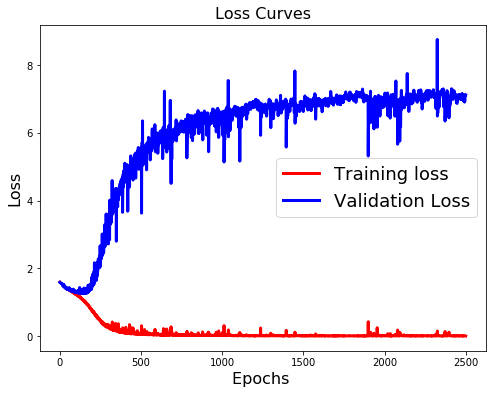

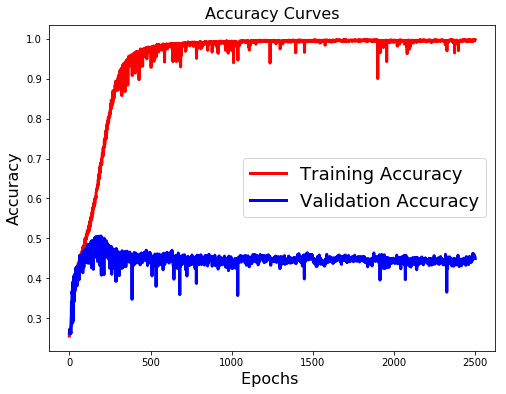

In [11]:
print("The following keys are stored in the training history:\n",
      history.history.keys())
print("loss history has len", len(history.history['loss']))
print(history.history['loss'])

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

plt.show()

## 9. Restoring a previously saved model

In [12]:
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('model_architecture.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('model_weights.h5')

## 10. Testing the trained model on new images

Shape of nr_test_images is (792, 100, 100, 3)
There are 792 test images.
For the first 100 test imagesI will also show the image.


TEST IMAGE # 0
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.4988675e-28 1.2805748e-33 1.0000000e+00 5.8186080e-18 0.0000000e+00]
Predicted category cats


/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


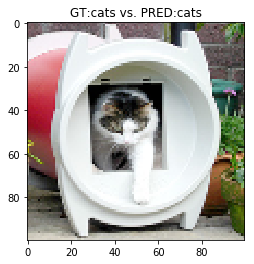



TEST IMAGE # 1
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [1.1162535e-06 2.7709897e-08 9.8088616e-01 1.9112639e-02 3.7315162e-14]
Predicted category cats


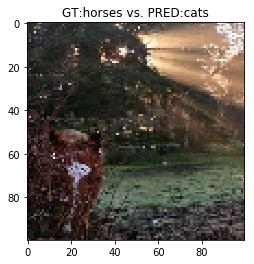



TEST IMAGE # 2
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [1.0000000e+00 5.6942399e-17 1.9707675e-11 4.9083311e-09 2.8224792e-17]
Predicted category birds


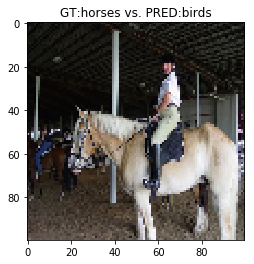



TEST IMAGE # 3
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [3.3485863e-09 4.3762884e-30 1.9912976e-30 9.9892956e-01 1.0704165e-03]
Predicted category dogs


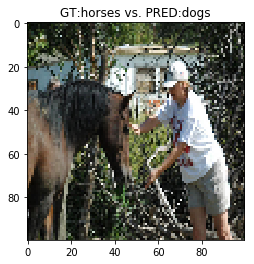



TEST IMAGE # 4
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [2.9963217e-15 8.9558663e-18 1.0000000e+00 8.5854657e-10 6.2467256e-31]
Predicted category cats


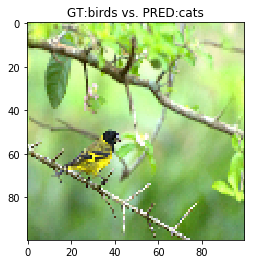



TEST IMAGE # 5
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [9.1473499e-05 1.1813570e-16 9.9990857e-01 4.4294959e-10 1.6088080e-32]
Predicted category cats


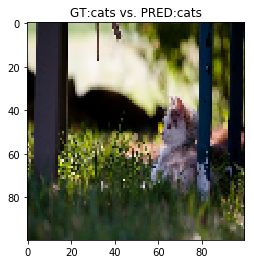



TEST IMAGE # 6
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [4.2627188e-10 9.9999166e-01 8.3228470e-06 6.0985954e-16 1.6924630e-12]
Predicted category mice


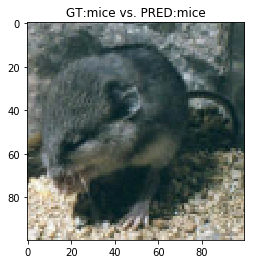



TEST IMAGE # 7
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [1.0000000e+00 7.0338448e-22 1.7730455e-26 5.5280338e-28 1.6520847e-28]
Predicted category birds


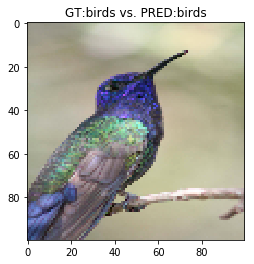



TEST IMAGE # 8
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [9.1026459e-07 6.5987524e-12 1.8420203e-11 9.9951959e-01 4.7952301e-04]
Predicted category dogs


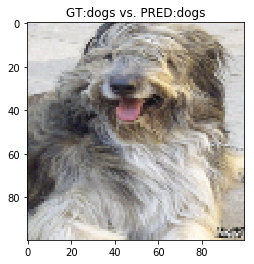



TEST IMAGE # 9
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [3.3411290e-10 2.0906408e-22 5.7402499e-23 9.9999785e-01 2.1175806e-06]
Predicted category dogs


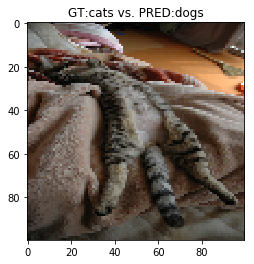



TEST IMAGE # 10
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [1.0000000e+00 2.6342009e-27 2.2890379e-17 1.9822329e-21 4.8576386e-35]
Predicted category birds


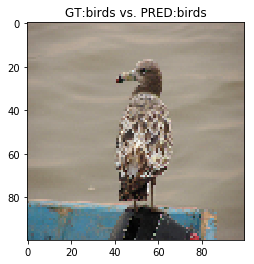



TEST IMAGE # 11
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [3.1034688e-07 8.0394093e-06 9.9995852e-01 3.3188022e-05 7.3972870e-17]
Predicted category cats


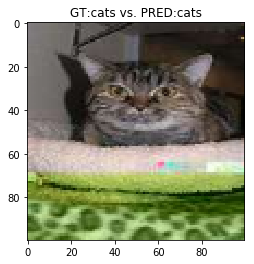



TEST IMAGE # 12
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [2.3266182e-03 7.5883435e-33 2.1153322e-34 9.9766785e-01 5.4453176e-06]
Predicted category dogs


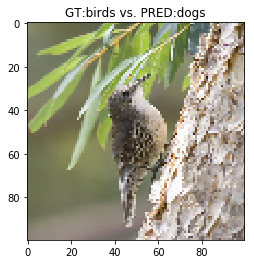



TEST IMAGE # 13
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [4.6224458e-11 6.5695007e-24 6.5013924e-16 1.0000000e+00 6.9376858e-18]
Predicted category dogs


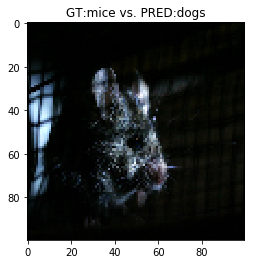



TEST IMAGE # 14
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.0000000e+00 1.9126284e-17 4.0800785e-08 3.0835855e-11 2.5083760e-23]
Predicted category birds


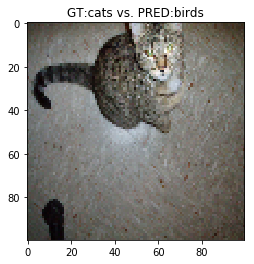



TEST IMAGE # 15
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [3.4029581e-04 9.7967452e-01 1.6655922e-23 9.0256258e-25 1.9985186e-02]
Predicted category mice


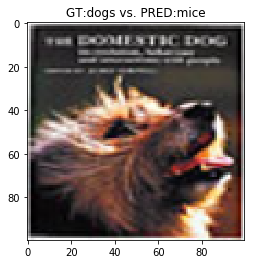



TEST IMAGE # 16
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [1.1792520e-06 1.2150242e-26 4.9486825e-12 9.9999881e-01 2.0335676e-23]
Predicted category dogs


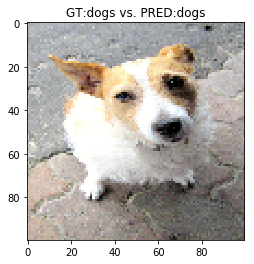



TEST IMAGE # 17
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [4.9286962e-05 1.9784749e-03 9.9797219e-01 1.7733653e-08 1.9442401e-14]
Predicted category cats


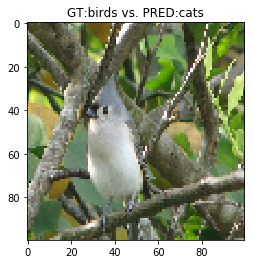



TEST IMAGE # 18
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [9.9999988e-01 9.0797016e-11 1.6298015e-08 8.5190521e-08 3.7230516e-13]
Predicted category birds


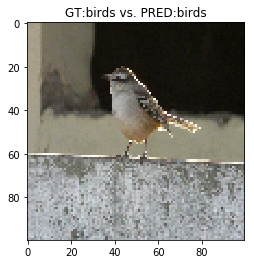



TEST IMAGE # 19
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [1.0000000e+00 0.0000000e+00 1.0979486e-25 1.5774936e-15 0.0000000e+00]
Predicted category birds


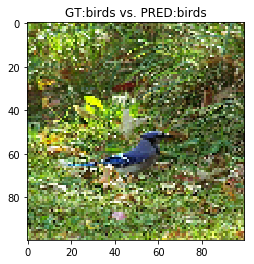



TEST IMAGE # 20
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [9.190701e-24 0.000000e+00 0.000000e+00 9.158431e-17 1.000000e+00]
Predicted category horses


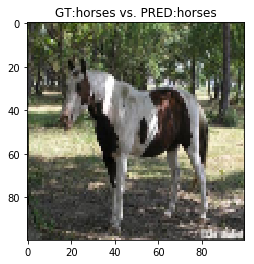



TEST IMAGE # 21
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [6.6382266e-03 2.4298546e-18 2.9815590e-21 1.9324744e-02 9.7403711e-01]
Predicted category horses


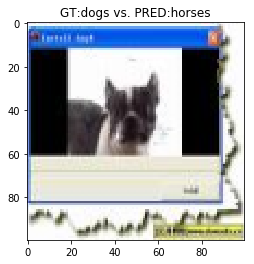



TEST IMAGE # 22
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.2473370e-07 9.8710001e-01 8.9792265e-03 2.6994650e-04 3.6506245e-03]
Predicted category mice


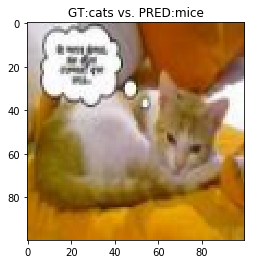



TEST IMAGE # 23
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [1.6935302e-01 1.5689033e-19 4.8363280e-10 8.3064705e-01 2.1387396e-14]
Predicted category dogs


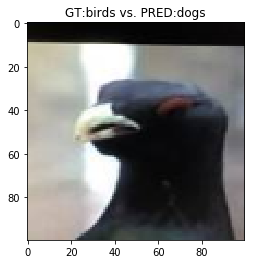



TEST IMAGE # 24
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [9.9973768e-01 3.9060802e-15 2.6225232e-04 8.4219209e-10 2.7908449e-24]
Predicted category birds


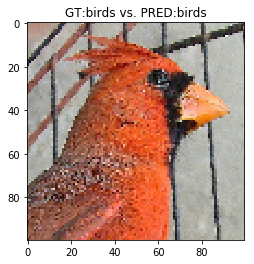



TEST IMAGE # 25
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [3.0514670e-07 2.8255593e-17 9.9999964e-01 7.0672526e-09 3.9758334e-28]
Predicted category cats


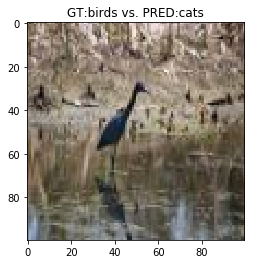



TEST IMAGE # 26
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [1.0000000e+00 2.7783300e-16 5.3636402e-09 1.7129375e-19 3.1809664e-29]
Predicted category birds


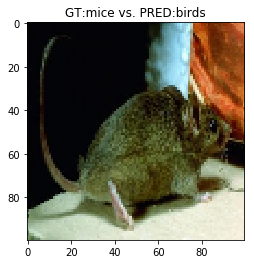



TEST IMAGE # 27
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [2.4878485e-13 9.9994874e-01 5.1266059e-05 1.0900956e-12 8.3342465e-11]
Predicted category mice


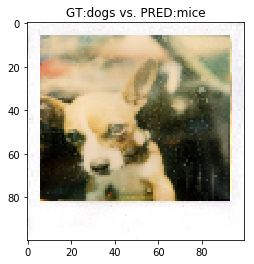



TEST IMAGE # 28
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.8871233e-11 9.9954599e-01 2.4939669e-13 1.7036056e-19 4.5403020e-04]
Predicted category mice


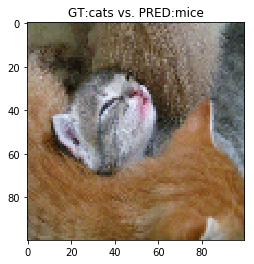



TEST IMAGE # 29
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [1.0343167e-15 1.0000000e+00 4.9594365e-14 1.6653566e-17 1.8858094e-12]
Predicted category mice


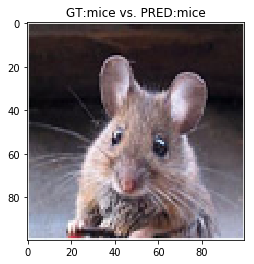



TEST IMAGE # 30
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [1.1154923e-13 2.6162125e-14 1.0000000e+00 5.7229324e-09 1.1763910e-25]
Predicted category cats


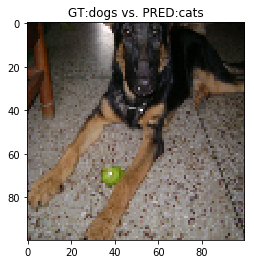



TEST IMAGE # 31
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.3001965e-04 9.0619734e-09 9.3085837e-01 6.9011547e-02 3.0706025e-14]
Predicted category cats


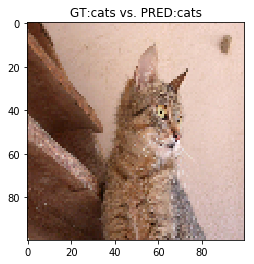



TEST IMAGE # 32
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [1.9114434e-07 1.6183012e-14 2.3539389e-08 9.9999976e-01 9.4896617e-13]
Predicted category dogs


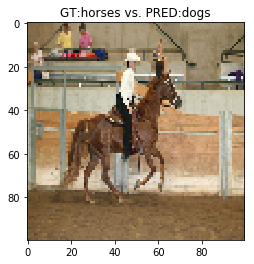



TEST IMAGE # 33
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [1.7385548e-16 8.5883801e-14 7.7289651e-23 1.2808127e-13 1.0000000e+00]
Predicted category horses


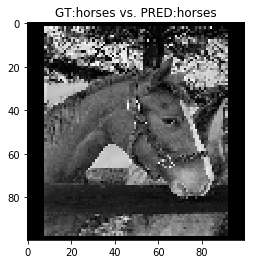



TEST IMAGE # 34
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [1.9028568e-30 7.0649076e-21 1.0000000e+00 9.6323873e-26 0.0000000e+00]
Predicted category cats


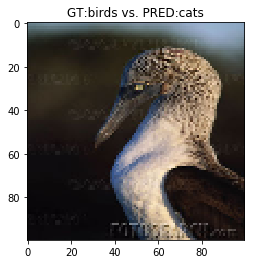



TEST IMAGE # 35
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [4.2120058e-22 1.7769628e-37 0.0000000e+00 1.1252269e-15 1.0000000e+00]
Predicted category horses


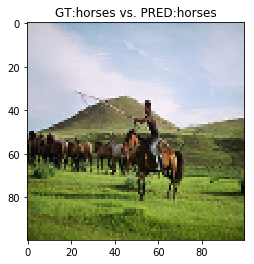



TEST IMAGE # 36
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [6.0892797e-20 1.8459966e-02 9.8154002e-01 1.4449116e-11 3.3842513e-17]
Predicted category cats


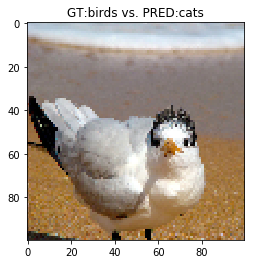



TEST IMAGE # 37
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [2.24101010e-15 1.00000000e+00 2.21822491e-11 1.52588622e-18
 1.06297255e-08]
Predicted category mice


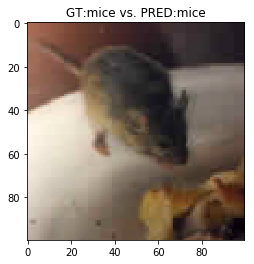



TEST IMAGE # 38
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [5.3728163e-06 4.9802104e-19 9.2294717e-01 7.7047452e-02 2.5644235e-27]
Predicted category cats


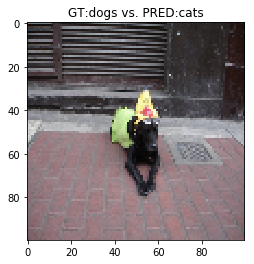



TEST IMAGE # 39
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.0000000e+00 3.4260331e-08 2.0621759e-24 1.6149110e-35 2.4501318e-21]
Predicted category birds


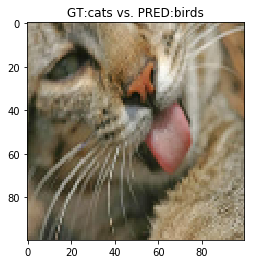



TEST IMAGE # 40
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [9.9999857e-01 1.4542775e-06 2.7346306e-13 8.8093183e-23 8.7104625e-18]
Predicted category birds


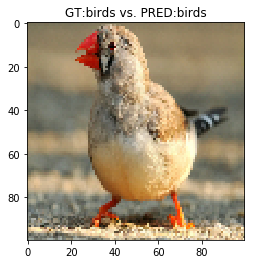



TEST IMAGE # 41
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [8.9220919e-02 4.7984932e-09 2.4607189e-01 6.6470724e-01 2.0662369e-12]
Predicted category dogs


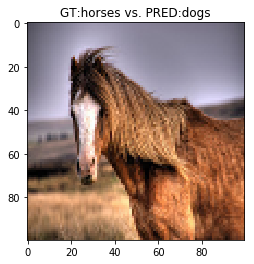



TEST IMAGE # 42
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [9.9960536e-01 1.1224587e-13 6.0198886e-15 3.9381994e-04 8.6806881e-07]
Predicted category birds


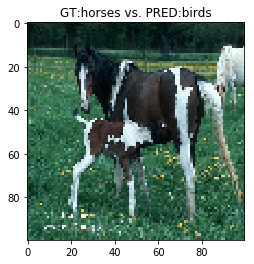



TEST IMAGE # 43
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [1.00000000e+00 6.91919823e-29 1.89350383e-20 1.08862114e-14
 2.96951743e-27]
Predicted category birds


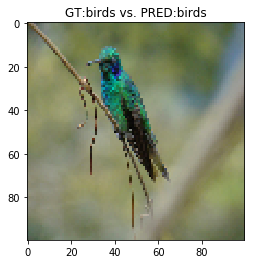



TEST IMAGE # 44
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [1.0000000e+00 2.1579542e-31 9.7996687e-30 7.1138908e-19 5.9863868e-26]
Predicted category birds


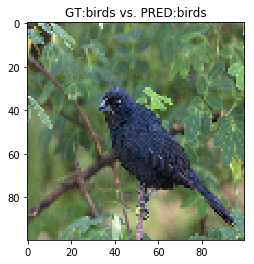



TEST IMAGE # 45
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.2933597e-05 4.7363374e-01 5.2623963e-01 8.5753229e-05 2.7941443e-05]
Predicted category cats


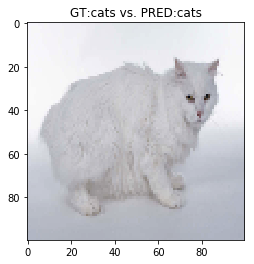



TEST IMAGE # 46
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [9.8410484e-05 1.3888545e-12 1.0221684e-05 9.9989128e-01 1.0478746e-12]
Predicted category dogs


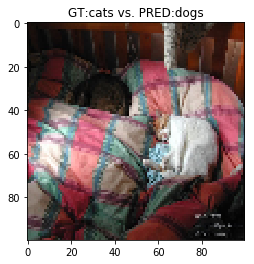



TEST IMAGE # 47
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.2986458e-15 1.1528825e-15 1.0000000e+00 2.2959961e-12 3.8892756e-30]
Predicted category cats


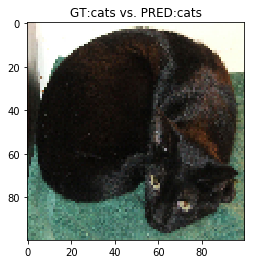



TEST IMAGE # 48
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [1.0000000e+00 9.3718642e-09 7.8422586e-14 2.8385923e-15 3.7820801e-12]
Predicted category birds


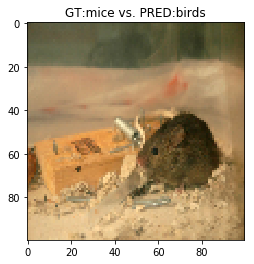



TEST IMAGE # 49
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [1.3620901e-01 1.0466703e-04 8.6360490e-01 8.1484533e-05 9.6586619e-12]
Predicted category cats


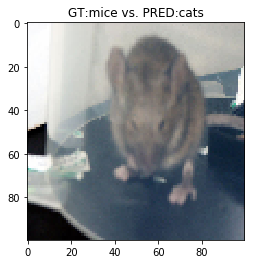



TEST IMAGE # 50
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [1.4948903e-32 5.1644631e-20 1.0000000e+00 3.1641707e-20 0.0000000e+00]
Predicted category cats


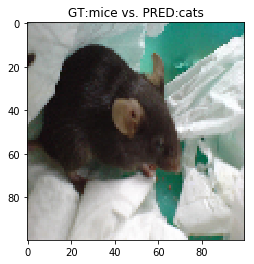



TEST IMAGE # 51
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [1.0000000e+00 1.4595127e-20 0.0000000e+00 0.0000000e+00 5.9030083e-17]
Predicted category birds


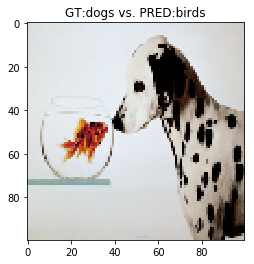



TEST IMAGE # 52
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [1.0403863e-06 1.3364495e-06 9.8123215e-31 1.0162886e-21 9.9999762e-01]
Predicted category horses


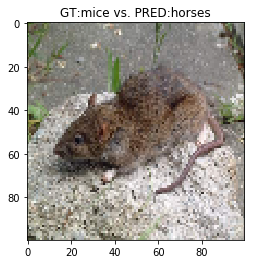



TEST IMAGE # 53
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [3.5253213e-15 1.6137447e-08 1.0000000e+00 4.1435296e-13 1.6157678e-27]
Predicted category cats


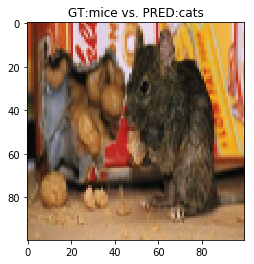



TEST IMAGE # 54
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [9.9992394e-01 2.4345541e-14 7.3785472e-05 2.2549689e-06 5.2611866e-19]
Predicted category birds


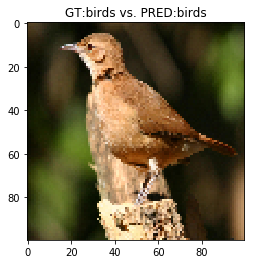



TEST IMAGE # 55
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.1181536e-14 1.9405822e-11 5.8361268e-01 4.1638729e-01 1.0141288e-22]
Predicted category cats


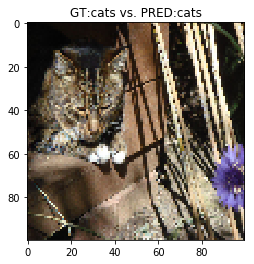



TEST IMAGE # 56
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [4.47019895e-12 9.96613204e-01 1.00487875e-10 1.41075008e-17
 3.38675594e-03]
Predicted category mice


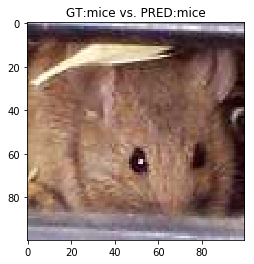



TEST IMAGE # 57
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [8.9966079e-10 2.9547509e-05 9.9997044e-01 8.1184810e-09 1.7989592e-12]
Predicted category cats


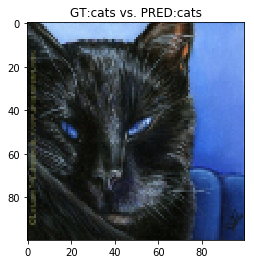



TEST IMAGE # 58
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [7.7797903e-14 3.1429789e-17 4.9301353e-32 1.7192090e-19 1.0000000e+00]
Predicted category horses


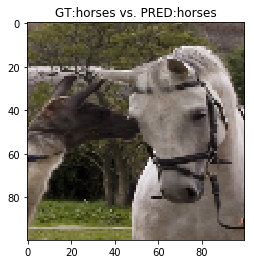



TEST IMAGE # 59
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [9.9997330e-01 3.0176505e-08 1.8618684e-18 4.1097182e-12 2.6658869e-05]
Predicted category birds


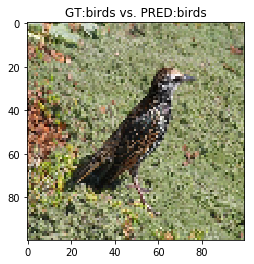



TEST IMAGE # 60
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [2.6911923e-19 1.6631202e-19 2.2106753e-35 6.4678212e-17 1.0000000e+00]
Predicted category horses


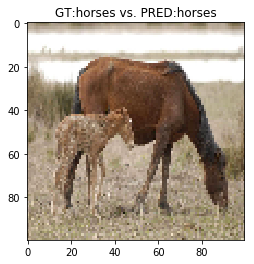



TEST IMAGE # 61
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [7.3976460e-04 9.9915588e-01 1.2408051e-06 3.8356467e-11 1.0310926e-04]
Predicted category mice


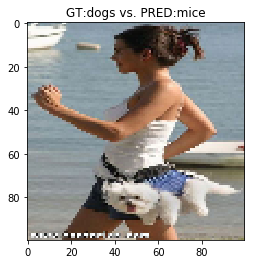



TEST IMAGE # 62
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [3.3809343e-13 3.5676606e-18 6.0025686e-36 3.1196679e-21 1.0000000e+00]
Predicted category horses


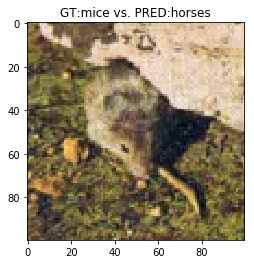



TEST IMAGE # 63
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [1.0000000e+00 1.0041316e-16 1.5614936e-33 5.3016377e-20 4.1354844e-09]
Predicted category birds


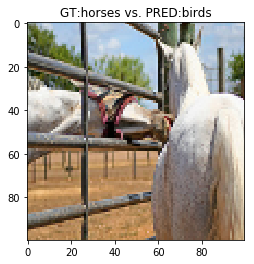



TEST IMAGE # 64
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [6.1944370e-06 2.4519265e-02 2.6726501e-12 5.1490743e-12 9.7547454e-01]
Predicted category horses


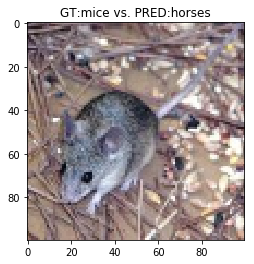



TEST IMAGE # 65
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [4.5104038e-02 3.2372286e-12 2.3806920e-14 2.2721811e-01 7.2767788e-01]
Predicted category horses


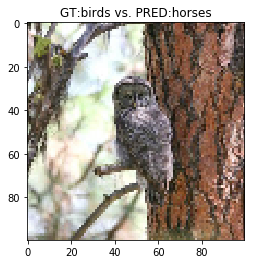



TEST IMAGE # 66
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [9.9016762e-01 8.1571831e-15 1.6996067e-03 8.1327958e-03 3.7656890e-22]
Predicted category birds


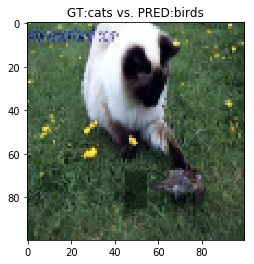



TEST IMAGE # 67
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [5.0164972e-30 4.4007631e-36 0.0000000e+00 4.0804197e-31 1.0000000e+00]
Predicted category horses


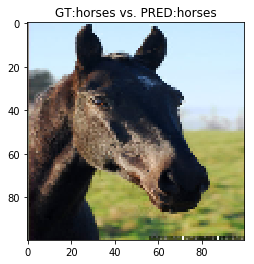



TEST IMAGE # 68
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [3.3496697e-08 1.5572601e-06 1.3461593e-09 9.9526936e-01 4.7290865e-03]
Predicted category dogs


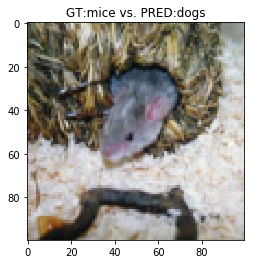



TEST IMAGE # 69
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [9.9999166e-01 3.1218785e-22 2.0347768e-14 8.3607847e-06 3.5781803e-18]
Predicted category birds


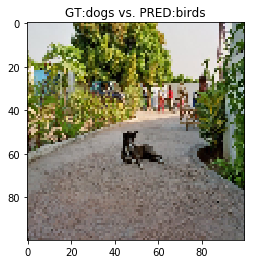



TEST IMAGE # 70
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [2.0088877e-17 2.7382050e-20 1.0000000e+00 2.0340694e-09 1.5867787e-34]
Predicted category cats


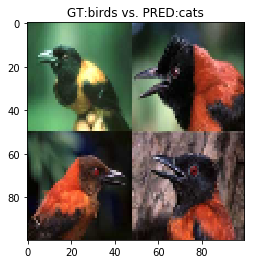



TEST IMAGE # 71
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [3.3964018e-13 2.6641134e-20 9.9999642e-01 3.5813530e-06 7.9549773e-33]
Predicted category cats


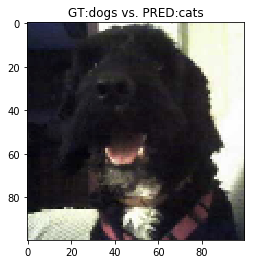



TEST IMAGE # 72
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [4.0879166e-01 2.1912808e-12 4.5115229e-20 8.2003125e-06 5.9120011e-01]
Predicted category horses


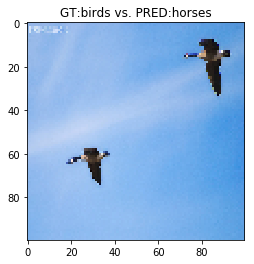



TEST IMAGE # 73
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [1. 0. 0. 0. 0.]
Predicted category birds


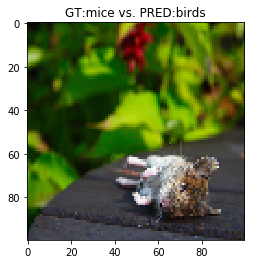



TEST IMAGE # 74
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [5.37223279e-08 1.16063048e-16 1.42310286e-09 1.00000000e+00
 1.10842494e-14]
Predicted category dogs


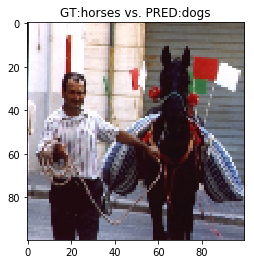



TEST IMAGE # 75
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [3.7500271e-13 1.0000000e+00 3.7429175e-09 1.7405559e-27 7.4237491e-23]
Predicted category mice


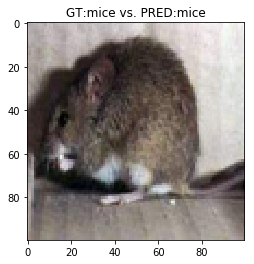



TEST IMAGE # 76
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [3.2517993e-09 3.0718175e-22 2.5918650e-23 9.1984951e-01 8.0150507e-02]
Predicted category dogs


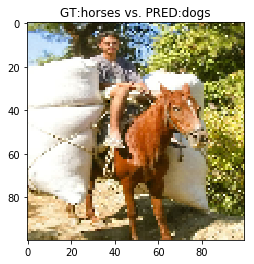



TEST IMAGE # 77
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [3.4601128e-25 7.3447421e-29 1.0000000e+00 1.4029236e-22 0.0000000e+00]
Predicted category cats


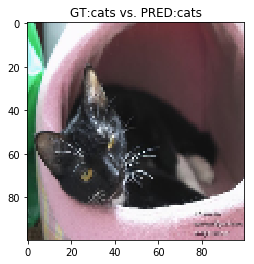



TEST IMAGE # 78
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.2438929e-16 3.8657684e-13 1.0000000e+00 5.2256730e-11 4.6415996e-26]
Predicted category cats


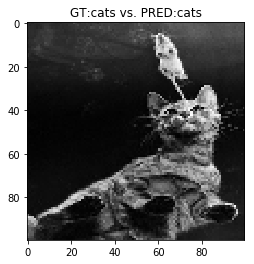



TEST IMAGE # 79
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [1.5931789e-02 1.8990901e-33 5.2926176e-15 9.8406821e-01 4.1554545e-25]
Predicted category dogs


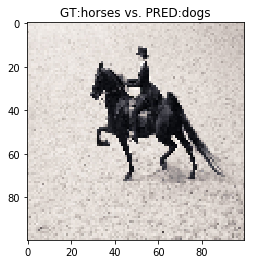



TEST IMAGE # 80
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [1.0000000e+00 9.0979654e-13 4.5518460e-16 2.2456633e-17 6.6667455e-17]
Predicted category birds


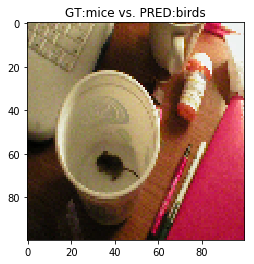



TEST IMAGE # 81
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [2.0334092e-36 3.5535861e-27 1.0000000e+00 0.0000000e+00 0.0000000e+00]
Predicted category cats


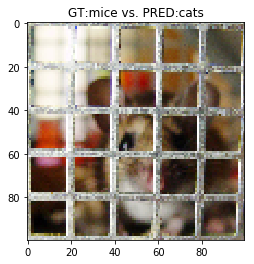



TEST IMAGE # 82
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [4.4908344e-12 7.4933895e-18 3.2890993e-28 2.2489963e-11 1.0000000e+00]
Predicted category horses


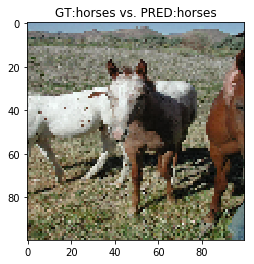



TEST IMAGE # 83
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [3.4917003e-23 3.3314590e-24 1.0000000e+00 7.8209730e-14 0.0000000e+00]
Predicted category cats


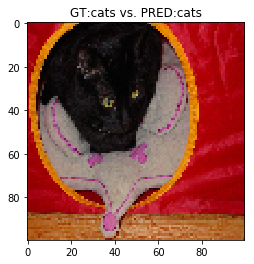



TEST IMAGE # 84
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.076757e-05 8.394869e-09 3.190170e-09 9.860626e-01 1.392658e-02]
Predicted category dogs


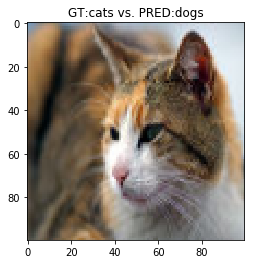



TEST IMAGE # 85
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [1.0000000e+00 7.8010135e-13 2.6147232e-16 1.4353482e-24 1.4425720e-24]
Predicted category birds


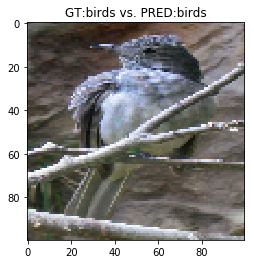



TEST IMAGE # 86
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [1.5986554e-13 9.2013243e-14 1.0273221e-17 4.2908450e-04 9.9957091e-01]
Predicted category horses


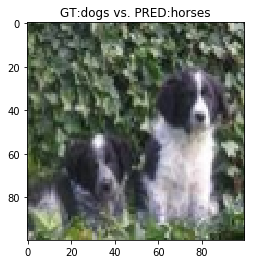



TEST IMAGE # 87
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [9.9999928e-01 1.9884089e-31 2.0442184e-21 7.1889639e-07 3.1453901e-23]
Predicted category birds


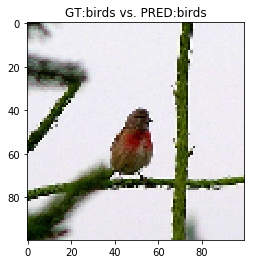



TEST IMAGE # 88
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [2.1018514e-03 4.2429388e-14 8.8029486e-01 1.1760334e-01 1.6864208e-18]
Predicted category cats


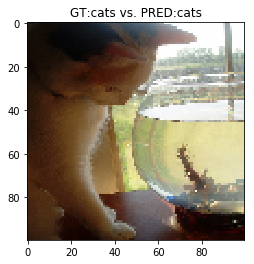



TEST IMAGE # 89
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [9.9332798e-01 6.6646473e-03 2.2644553e-10 5.6516033e-12 7.3385854e-06]
Predicted category birds


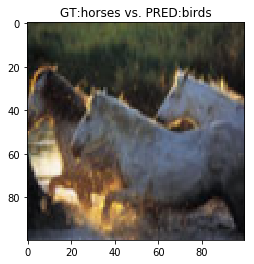



TEST IMAGE # 90
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.7553518e-12 5.3332226e-08 1.8559619e-25 6.8284352e-25 1.0000000e+00]
Predicted category horses


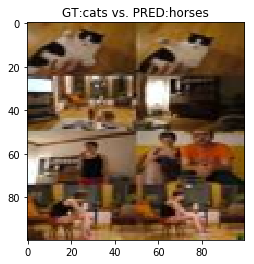



TEST IMAGE # 91
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [1.19280035e-14 2.13953435e-24 9.87199843e-01 1.28002288e-02
 1.16623603e-37]
Predicted category cats


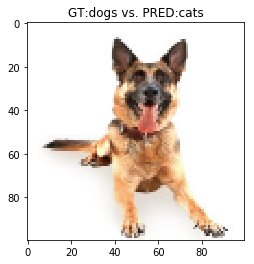



TEST IMAGE # 92
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [1.0000000e+00 1.6339641e-22 1.0105354e-20 3.2054692e-10 2.5402193e-16]
Predicted category birds


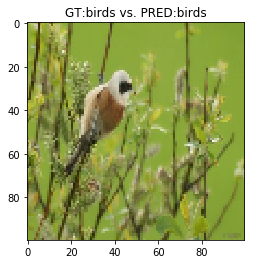



TEST IMAGE # 93
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [5.5038643e-01 4.4960746e-01 6.0905454e-06 2.1289452e-13 1.8786113e-10]
Predicted category birds


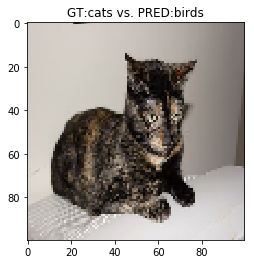



TEST IMAGE # 94
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [8.8381070e-01 4.4272525e-08 2.5741212e-05 1.1616359e-01 8.3353124e-10]
Predicted category birds


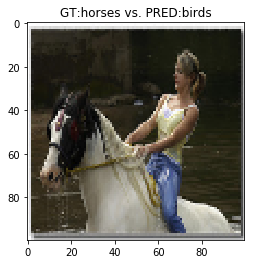



TEST IMAGE # 95
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [9.9961072e-01 3.5490930e-07 2.8851946e-16 5.0354798e-10 3.8893183e-04]
Predicted category birds


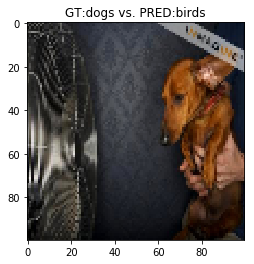



TEST IMAGE # 96
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [1. 0. 0. 0. 0.]
Predicted category birds


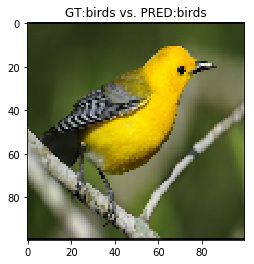



TEST IMAGE # 97
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [6.6300693e-18 2.2525612e-17 1.0000000e+00 5.8923336e-13 6.1318146e-32]
Predicted category cats


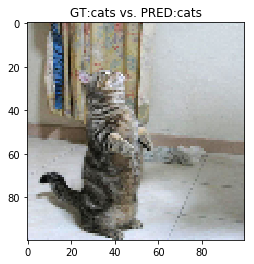



TEST IMAGE # 98
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [3.4489626e-11 8.7823743e-26 2.0254258e-15 1.0000000e+00 1.2692648e-22]
Predicted category dogs


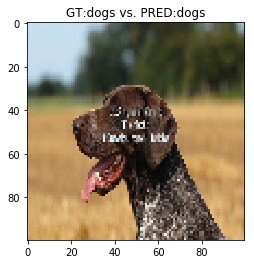



TEST IMAGE # 99
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [6.8051577e-02 7.4117990e-05 6.0027715e-13 1.9682972e-08 9.3187422e-01]
Predicted category horses


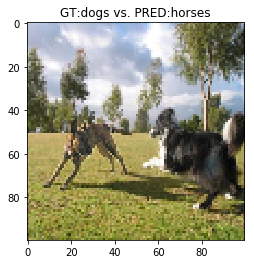



TEST IMAGE # 100
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [1.0000000e+00 9.4425086e-27 6.3166768e-37 9.6367040e-15 2.0725484e-11]
Predicted category birds


TEST IMAGE # 101
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [2.1667761e-11 7.5683766e-07 9.9999917e-01 1.1315452e-07 6.3274235e-16]
Predicted category cats


TEST IMAGE # 102
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [1.000000e+00 6.090486e-31 6.958435e-34 7.267850e-28 6.980859e-31]
Predicted category birds


TEST IMAGE # 103
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [4.1097728e-06 2.0692371e-23 2.9266514e-17 9.9999595e-01 1.2798636e-11]
Predicted category dogs


TEST IMAGE # 104
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [6.2129701e-19 4.6043764e-24 1.0000000e+00 4.0505937e-25 0.0000000e+00]
Predicted category cats


TEST IMAGE # 105
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [8.5626330e-22 2.5462943e-11 1.0000000e+00 1.6

model_outputs= [4.3910426e-05 6.9975732e-07 2.3342624e-04 9.9971563e-01 6.3752373e-06]
Predicted category dogs


TEST IMAGE # 169
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [9.3746044e-10 1.8796939e-10 9.0352207e-01 9.6477941e-02 1.5630812e-17]
Predicted category cats


TEST IMAGE # 170
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [9.9999642e-01 1.4093604e-15 3.9494641e-10 3.5392372e-06 1.9280481e-14]
Predicted category birds


TEST IMAGE # 171
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [4.7581513e-32 1.0695044e-31 1.0000000e+00 9.8980825e-19 0.0000000e+00]
Predicted category cats


TEST IMAGE # 172
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [1.0000000e+00 2.7488555e-30 2.1277431e-38 1.1076865e-08 1.7450969e-08]
Predicted category birds


TEST IMAGE # 173
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [1.0000000e+00 4.3166531e-19 5.1160022e-16 1.0019665e-15 1.0250280e-21]
Predicted category birds


TEST 

TEST IMAGE # 216
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [9.9999785e-01 7.9361047e-07 2.7048435e-12 1.0387936e-09 1.3232740e-06]
Predicted category birds


TEST IMAGE # 217
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [4.2885134e-15 1.0000000e+00 2.2099783e-10 2.1500971e-25 7.6748800e-22]
Predicted category mice


TEST IMAGE # 218
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [2.6436237e-19 4.2698654e-18 1.0000000e+00 6.3798045e-16 1.2255222e-34]
Predicted category cats


TEST IMAGE # 219
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [7.8663551e-31 0.0000000e+00 0.0000000e+00 1.9662513e-14 1.0000000e+00]
Predicted category horses


TEST IMAGE # 220
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [3.27600246e-05 1.18052447e-03 1.29022424e-17 8.62552576e-17
 9.98786747e-01]
Predicted category horses


TEST IMAGE # 221
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [3.0283059e-04 2.3298052e-10 9.99

[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [1.2121372e-13 6.0207433e-01 3.9791116e-01 1.4018330e-05 4.9536703e-07]
Predicted category mice


TEST IMAGE # 269
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [9.9401629e-01 4.7479440e-05 2.4734934e-10 1.2369934e-07 5.9360485e-03]
Predicted category birds


TEST IMAGE # 270
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [8.4028194e-08 1.4322704e-16 7.3576458e-22 9.9773741e-01 2.2624116e-03]
Predicted category dogs


TEST IMAGE # 271
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [1.6101900e-16 1.1964334e-21 1.4215299e-31 4.6720563e-15 1.0000000e+00]
Predicted category horses


TEST IMAGE # 272
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [1.9705032e-10 3.1724330e-02 9.6827501e-01 6.9136348e-07 3.4713332e-10]
Predicted category cats


TEST IMAGE # 273
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [6.4202262e-11 2.1944013e-27 7.0771958e-13 1.0000000e+00 

model_outputs= [3.3568082e-07 3.8085930e-13 1.4370610e-07 9.9999952e-01 5.9603750e-14]
Predicted category dogs


TEST IMAGE # 319
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [2.3381265e-15 1.8779448e-27 3.0725157e-13 1.0000000e+00 1.7303541e-27]
Predicted category dogs


TEST IMAGE # 320
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [2.8408606e-02 2.9283080e-16 9.7059548e-01 9.9593331e-04 3.3986589e-24]
Predicted category cats


TEST IMAGE # 321
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [1.6341023e-13 1.2300293e-07 9.9999988e-01 3.2133960e-14 5.0367009e-25]
Predicted category cats


TEST IMAGE # 322
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.5779703e-17 9.5129299e-06 9.9999046e-01 5.3172413e-13 9.7446881e-18]
Predicted category cats


TEST IMAGE # 323
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [3.2771283e-08 4.5549246e-18 3.4571503e-18 9.9503607e-01 4.9638981e-03]
Predicted category dogs


TEST IMAGE

model_outputs= [7.0807523e-34 1.3293943e-26 1.0000000e+00 1.4409707e-25 0.0000000e+00]
Predicted category cats


TEST IMAGE # 367
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [3.2780332e-09 6.1747813e-21 2.8723097e-19 1.0000000e+00 7.3776576e-09]
Predicted category dogs


TEST IMAGE # 368
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [1.0000000e+00 0.0000000e+00 2.8757664e-32 0.0000000e+00 0.0000000e+00]
Predicted category birds


TEST IMAGE # 369
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [1.2518288e-04 1.6783883e-09 5.7287145e-13 1.0425388e-01 8.9562094e-01]
Predicted category horses


TEST IMAGE # 370
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [7.1154016e-10 5.2215099e-14 1.2348919e-07 9.9999988e-01 1.9040329e-15]
Predicted category dogs


TEST IMAGE # 371
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [2.0271655e-05 1.4430217e-09 1.3195257e-05 9.9996650e-01 3.9359380e-10]
Predicted category dogs


TEST I

model_outputs= [1.0000000e+00 1.1490032e-19 3.2158201e-24 7.9955092e-23 3.5296686e-22]
Predicted category birds


TEST IMAGE # 419
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.3766983e-01 3.8431103e-09 4.4950834e-03 8.5783505e-01 3.9607307e-11]
Predicted category dogs


TEST IMAGE # 420
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [2.0265017e-05 3.9356864e-13 1.0496968e-02 9.8948276e-01 9.8922893e-18]
Predicted category dogs


TEST IMAGE # 421
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [1.0000000e+00 1.9891864e-36 1.9353165e-37 1.6120820e-17 4.2398297e-22]
Predicted category birds


TEST IMAGE # 422
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [9.9937552e-01 1.1180570e-11 6.1912206e-04 5.3959907e-06 9.6173133e-17]
Predicted category birds


TEST IMAGE # 423
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [9.8701173e-01 6.4409074e-17 2.3785840e-13 1.2988273e-02 6.0684469e-10]
Predicted category birds


TEST IM

model_outputs= [6.7633872e-12 1.1349496e-13 9.9999082e-01 9.1387674e-06 2.7934846e-28]
Predicted category cats


TEST IMAGE # 483
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [2.1109583e-09 1.6904885e-21 6.0070902e-33 1.8671296e-09 1.0000000e+00]
Predicted category horses


TEST IMAGE # 484
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.6588822e-18 2.2744752e-10 1.0000000e+00 9.7627048e-20 8.1270008e-30]
Predicted category cats


TEST IMAGE # 485
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [6.9232153e-13 7.3661678e-17 1.0000000e+00 9.8182434e-12 2.7235339e-30]
Predicted category cats


TEST IMAGE # 486
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [3.9679269e-20 4.0603885e-09 1.0000000e+00 2.5169686e-12 1.6413715e-24]
Predicted category cats


TEST IMAGE # 487
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [5.5743993e-04 1.6823623e-03 6.9151647e-06 9.6106923e-01 3.6684059e-02]
Predicted category dogs


TEST IMA

[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [3.4518091e-09 1.3369782e-13 1.0000000e+00 3.0527831e-09 3.2060056e-26]
Predicted category cats


TEST IMAGE # 531
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [5.2730762e-12 1.5783202e-19 9.8729777e-01 1.2702289e-02 1.4682998e-30]
Predicted category cats


TEST IMAGE # 532
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [2.61026489e-05 5.28677765e-18 9.99854803e-01 1.19049306e-04
 1.47820651e-25]
Predicted category cats


TEST IMAGE # 533
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.0000000e+00 1.1144446e-12 2.6051060e-12 7.2770434e-10 7.4317736e-14]
Predicted category birds


TEST IMAGE # 534
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [8.5048401e-17 2.1602577e-26 0.0000000e+00 1.3765163e-25 1.0000000e+00]
Predicted category horses


TEST IMAGE # 535
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [4.9567800e-05 6.3909239e-11 9.9994969e-01 7.6826956e-07

[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [2.4080555e-12 4.7459633e-11 9.9999952e-01 5.1765119e-07 1.0040755e-20]
Predicted category cats


TEST IMAGE # 579
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.41404025e-05 8.36819914e-18 9.78831589e-01 2.11543366e-02
 2.05953525e-25]
Predicted category cats


TEST IMAGE # 580
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [8.7399874e-09 1.5417953e-33 1.7454717e-17 1.0000000e+00 5.2003486e-26]
Predicted category dogs


TEST IMAGE # 581
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [3.2855147e-12 1.7999715e-18 9.0035491e-33 1.1412167e-12 1.0000000e+00]
Predicted category horses


TEST IMAGE # 582
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [3.7699490e-07 2.0967783e-11 1.0055093e-27 1.1618344e-17 9.9999964e-01]
Predicted category horses


TEST IMAGE # 583
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [1.1341748e-02 7.2061971e-06 9.8865068e-01 3.1793019e

model_outputs= [1. 0. 0. 0. 0.]
Predicted category birds


TEST IMAGE # 627
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [6.9413269e-05 2.6619321e-16 9.9993062e-01 2.8370115e-10 1.2107802e-29]
Predicted category cats


TEST IMAGE # 628
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [1.8600667e-13 3.3897438e-12 9.9981898e-01 1.8102686e-04 1.3049579e-26]
Predicted category cats


TEST IMAGE # 629
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [8.6781797e-16 6.5289396e-28 0.0000000e+00 8.7152302e-10 1.0000000e+00]
Predicted category horses


TEST IMAGE # 630
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [4.6353243e-02 1.9939294e-20 2.1667569e-16 9.5364678e-01 7.1345274e-10]
Predicted category dogs


TEST IMAGE # 631
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [1.0372809e-02 6.4055655e-07 2.4579728e-20 2.8157202e-13 9.8962653e-01]
Predicted category horses


TEST IMAGE # 632
[0. 1. 0. 0. 0.]
Ground truth category: 

model_outputs= [1.0000000e+00 1.1116126e-23 1.3589503e-31 3.2100890e-21 5.9917595e-17]
Predicted category birds


TEST IMAGE # 677
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [1.4000706e-12 1.0927772e-11 4.5831055e-23 5.9676613e-13 1.0000000e+00]
Predicted category horses


TEST IMAGE # 678
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [7.8438974e-12 9.6337143e-14 1.0000000e+00 1.3592363e-11 1.3312199e-28]
Predicted category cats


TEST IMAGE # 679
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [6.7078801e-08 1.2369025e-02 1.7561764e-04 4.1963542e-03 9.8325896e-01]
Predicted category horses


TEST IMAGE # 680
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [2.3669237e-03 2.3750584e-01 7.5590569e-01 4.2212303e-03 2.7294001e-07]
Predicted category cats


TEST IMAGE # 681
[0. 1. 0. 0. 0.]
Ground truth category: mice
model_outputs= [9.6837099e-04 8.7929398e-01 1.1973763e-01 1.8452148e-08 2.0456616e-10]
Predicted category mice


TEST 

[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [1.3811605e-16 3.8987026e-05 9.9996102e-01 1.0476972e-17 1.5482914e-15]
Predicted category cats


TEST IMAGE # 726
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [1.1081610e-09 4.1354600e-01 2.7724382e-06 2.8820191e-06 5.8644831e-01]
Predicted category horses


TEST IMAGE # 727
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [6.7134810e-05 9.9993289e-01 2.5007651e-08 4.3957655e-23 5.0344737e-09]
Predicted category mice


TEST IMAGE # 728
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [5.3210676e-09 1.3968981e-17 3.9716763e-12 1.0000000e+00 8.8221889e-13]
Predicted category dogs


TEST IMAGE # 729
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [2.3474509e-07 9.9575545e-26 1.7282960e-29 9.9992859e-01 7.1196773e-05]
Predicted category dogs


TEST IMAGE # 730
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [3.06698289e-09 1.71830670e-05 9.99982834e-01 1.27927436e

[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [1.45068990e-16 3.30554417e-10 1.00000000e+00 7.89066989e-12
 1.04015255e-23]
Predicted category cats


TEST IMAGE # 778
[1. 0. 0. 0. 0.]
Ground truth category: birds
model_outputs= [9.9655461e-01 5.1013854e-18 4.0429075e-26 1.6251053e-06 3.4437734e-03]
Predicted category birds


TEST IMAGE # 779
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [3.1798557e-09 4.6922031e-04 9.9947292e-01 5.7941663e-05 7.7404760e-13]
Predicted category cats


TEST IMAGE # 780
[0. 0. 0. 1. 0.]
Ground truth category: dogs
model_outputs= [9.9996269e-01 1.5952892e-19 1.0399016e-06 3.6229718e-05 8.8033255e-23]
Predicted category birds


TEST IMAGE # 781
[0. 0. 1. 0. 0.]
Ground truth category: cats
model_outputs= [2.3380348e-32 5.8679513e-28 1.0000000e+00 6.2581522e-23 0.0000000e+00]
Predicted category cats


TEST IMAGE # 782
[0. 0. 0. 0. 1.]
Ground truth category: horses
model_outputs= [9.4814531e-11 2.5009940e-30 2.3482789e-34 9.9486464e-

In [13]:
import scipy.misc

NR_TEST_IMAGES_TO_SHOW = 100

print("Shape of nr_test_images is", X_test.shape)

nr_test_images = X_test.shape[0]
print("There are", nr_test_images, "test images.")
print("For the first", NR_TEST_IMAGES_TO_SHOW, "test images"
      "I will also show the image.")

correctly_classified = 0
for test_img_nr in range(0, nr_test_images):
    
    print("\n\nTEST IMAGE #", test_img_nr)
    
    # get the image from the 4D NumPy array
    img_data = X_test[test_img_nr]
    
    # convert NumPy data back to an OpenCV image
    # in order to display it correctly
    testimg = scipy.misc.toimage(img_data)
    
    
    # get ground truth label for this image
    print(Y_test_one_hot_encoded[test_img_nr])
    gt_cat = np.argmax(Y_test_one_hot_encoded[test_img_nr])
    gt_cat_name = categories[gt_cat]
    print("Ground truth category:", gt_cat_name)
    
    
    # let our trained model predict the class!
    img_data_as_4d_array = img_data.reshape((-1,
                                             img_data.shape[0],
                                             img_data.shape[1],
                                             img_data.shape[2])
                                           )    
    model_outputs = model.predict(img_data_as_4d_array)
    
    
    # get predicted class from 2D output matrix
    model_outputs = model_outputs.reshape(-1)
    print("model_outputs=", model_outputs)
    predicted_cat = np.argmax(model_outputs)
    predicted_cat_name = categories[predicted_cat]
    print("Predicted category", predicted_cat_name)
    
    
    # was the prediction correct?
    if predicted_cat == gt_cat:
        correctly_classified += 1
    
    
    # show the image?
    if (test_img_nr < NR_TEST_IMAGES_TO_SHOW):
        plt.title("GT:"+gt_cat_name+" vs. PRED:"+predicted_cat_name)
        plt.imshow(testimg)
        plt.show()
    
    


So it's getting interesting! How many of the images were correctly classified?

In [14]:
print("The CNN correctly classified", correctly_classified,
      "of the", nr_test_images, "test images.")
correct_ratio_percent = correctly_classified*100.0/nr_test_images
print("Correct classification rate:", correct_ratio_percent, "%")

The CNN correctly classified 363 of the 792 test images.
Correct classification rate: 45.833333333333336 %


Here is the model again:

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 96, 96, 32)        2432      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 47, 47, 64)        8256      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 22, 22, 64)        16448     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 10, 10, 64)        16448     
__________